In [ ]:
pip install klib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer 
import pandas_profiling as pp
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline
import klib

### 데이터불러오기

In [ ]:
path = "/content/drive/MyDrive/ML Competition"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
survey = pd.read_csv(path+'/survey.csv', encoding='utf-8')
panel = pd.read_csv(path+'/panel.csv', encoding='utf-8')
response_train = pd.read_csv(path+'/response_train.csv', encoding='utf-8')
response_test = pd.read_csv(path+'/response_test.csv', encoding='utf-8')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
y_train = train["STATUS"]

In [ ]:
# train에만 존재하는 GENDER, BIRTH 결측값 가진 userID제거
panel = panel.drop(index = panel[panel.userID == "p08142"].index)


# panel의 SQ1의 결츨값을 GENDER로 메꾸기
for i in panel[panel.SQ2.isnull()].index:
  panel.loc[i, "SQ1"] = panel.loc[i, "GENDER"]


# penal의 SQ2의 결측값을 BIRTH로 메꾸기
for i in panel[panel.SQ2.isnull()].index:
  panel.loc[i, "SQ2"] = panel.loc[i, "BIRTH"]

# SQ2에 생년월일 대답 이상하게 한 사람...
idx = panel[panel.SQ2 < 10].index
panel.loc[idx, "SQ2"] = panel.loc[idx, "BIRTH"]

# REGION 열 변환용 사전
region_lst = ["서울", "세종", "인천", "대전", "광주", "대구", "울산", "부산", "경기", "강원", "충북", "충남", "전북", "전남", "경북", "경남", "제주"]
pow_lst = [np.power(2, i) for i in range(1, 18)]
region_dict = {x:y for x, y in zip(pow_lst, region_lst)}

# SQ3 열 변환용 사전
sq3_lst = ["서울", "부산", "대구", "울산", "광주", "대전", "인천", "경기", "충북", "충남", "경북", "경남", "전북", "전남", "강원", "제주", "세종", "기타/해외"]
idx_lst = list(range(1, 18))
idx_lst.append(97)
idx_lst = list(map(float, idx_lst))
sq3_dict = {x:y for x, y in zip(idx_lst, sq3_lst)}

# SQ3 데이터타입 통일 (최종 float으로 바꿔주기)
panel.SQ3 = panel.SQ3.astype("str")

def clean(x):
  if "," in x:
    return "1"
  else:
    return x

panel.SQ3 = panel.SQ3.map(clean)
panel.SQ3 = panel.SQ3.astype("float64")

# REGION과 SQ3 최종변환
panel["REGION"] = panel["REGION"].map(region_dict)
panel["SQ3"] = panel["SQ3"].map(sq3_dict)

# SQ3 결측값을 REGION으로 메꾸기
for i in panel[panel.SQ3.isnull()].index:
  panel.loc[i, "SQ3"] = panel.loc[i, "REGION"]

# panel 신상정보faetures drop
panel = panel.drop(["REGION", "GENDER", "BIRTH"], axis = 1)

# SQ 1, 2, 3에 새로운 이름
panel = panel.rename(columns = {"SQ1" : "GENDER", "SQ2" : "BIRHT", "SQ3": "REGION"})

train = response_train.merge(panel).merge(survey)
test = response_test.merge(panel).merge(survey).sort_values(by='ID')
test = test.drop("ID", axis = 1)
# print(train.head(), train.info(), train.isnull().sum())

In [ ]:
panel

,userID,TYPE,GENDER,BIRHT,REGION,SQ4,SQ5,SQ6,SQ7,SQ8,A1,B1,B2,B3,B4,B5,C1,C2,C3,F1,F2,H1,T1,X1,X2,X3,X4,DQ1,DQ2,DQ3,DQ4,DQ5,DQ6,DQ7
0,p00005,D,2.0,1979.0,서울,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p03884,D,1.0,1970.0,경기,1,3.0,2,4.0,3,"7,8",4,4,2,"1,5",6,"1,10,5,6,7,8",2,"1,9",1,1,"1,3",99,5,1.0,2,2,8,1,21,1,8.0,5.0,1.0
2,p02205,D,2.0,1957.0,서울,2,3.0,1,99.0,2,99,3,3,1,2,5,"2,3",3,"1,10,2,3,4,5,6,9",3,1,99,99,2,1.0,"4,",1,5,12,2,7,1.0,6.0,3.0
3,p12630,B,1.0,1997.0,경기,3,1.0,1,"1,10,13,18,2,3,4,5,6,7,8",3,3,9,2,3,1,99,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p14431,C,2.0,1992.0,경기,1,3.0,1,3.0,"1,13,2,21,3,4,5,6,9",3,3,5,9997,2,"10,2,3,5,6,8,9",4,2,"2,4,7,9",99,99,99,99,99,2.0,4,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16558,p01702,D,1.0,1988.0,경기,1,3.0,2,9.0,3,"17,18,3",8,1,1,"1,2,5",4,"1,10,12,2,3,6,9",2,"2,4,6",7,2,"1,2,3",3,20,1,2,3,4,1,19,2,8.0,9.0,1.0
16559,p05868,B,1.0,1993.0,경기,"1,",3,1,99,4,"1,10,12,13,15,16,18,2,3,4,5,7,8,9",8,4,1,"1,2,5,6","6,","11,9,1,3","5,","6,4","3,","2,",16,2,1,1,4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16560,p09312,B,1.0,1999.0,인천,1,1,3,"1,13,18,2,4,5,8,9",5,3,9,99,99,99,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16561,p09181,D,1.0,1997.0,대구,"1,",2,"1,",99,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train = response_train.merge(panel).merge(survey)
test = response_test.merge(panel).merge(survey).sort_values(by='ID')

In [ ]:
features = pd.concat([train, test]).reset_index(drop=True)
features

,userID,surveyID,TIME,STATUS,TYPE,GENDER,BIRHT,REGION,SQ4,SQ5,SQ6,SQ7,SQ8,A1,B1,B2,B3,B4,B5,C1,C2,C3,F1,F2,H1,T1,X1,X2,X3,X4,DQ1,DQ2,DQ3,DQ4,DQ5,DQ6,DQ7,TITLE,IR,LOI,CATEGORIES,CPI,ID
0,p04802,s00004,2020-06-01 02:30:11,0.0,B,2.0,1990.0,경기,3,1,4,"1,13,15,18,2,3,4,5,9",5,2,99,99,99,99,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
1,p04685,s00004,2020-06-01 02:30:11,0.0,B,2.0,1984.0,인천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
2,p01206,s00004,2020-06-01 02:30:11,1.0,D,2.0,1983.0,대전,"1,",3.0,"2,",3.0,4,"1,10,11,14,15,16,17,18,2,20,6,7,9",8,3,1,"1,2,3,4,6,8",3,"13,15,2,4,6,8",8,"3,5,6,7,9",6,1,"10,3,5,6,7,8","4,,","15,",1.0,"1,",4,4,9,18,3,8.0,7.0,1.0,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
3,p00423,s00004,2020-06-01 02:30:11,1.0,D,1.0,1994.0,서울,"1,",3.0,"1,",1.0,4,"13,14,15,17,18,2,21,22,3,6,7,8",8,3,1,"1,2,3,5,7",3,"10,13,14,5",8,"1,2,3,4,5,6,7,8,9","2,","3,","11,5,6","9,,","15,",1.0,"3,",1,4,16,99,"1,",3.0,2.0,1.0,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
4,p00328,s00004,2020-06-01 02:30:11,1.0,D,2.0,1981.0,서울,"5,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259805,p13243,s05675,2021-09-12 09:44:07,NaN,B,1.0,1995.0,서울,"4,",3.0,1,99,4,"1,13,2,3,4,5,7,8,9",5,3,3,"1,5","8,",99,"8,",6,"5,","99,","2,1,3,11,4",16,2,2.0,"3,",1.0,4,8,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (G-992341),100,16,NaN,880.0,1355512.0
6259806,p13644,s05597,2021-09-05 07:04:40,NaN,C,2.0,1980.0,경기,1,3.0,2,3.0,"1,13,15,2,21,4,5,6,7,8,9",1,3,"1,2,4,5",2,8,"10,6",2,2,"1,2,3,4,5",99,99,99,99,8,6.0,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (G-987381),100,16,NaN,880.0,1355513.0
6259807,p15308,s05597,2021-09-05 02:34:38,NaN,C,2.0,1984.0,서울,1,4.0,1,3.0,"1,10,11,12,13,14,15,16,17,19,2,21,3,4,5,7,9",4,2,1,3,2,"10,4,6",5,99,"1,2,3,4,9",99,15,1,1,9,5.0,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (G-987381),100,16,NaN,880.0,1355514.0
6259808,p13465,s05868,2021-10-05 00:30:49,NaN,C,1.0,1987.0,부산,1,3.0,1,3.0,"1,10,13,2,21,4,5,7",5,2,99,3,2,"10,2,3,9",3,99,"1,2,3,4",16,99,99,99,99,19.0,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (G-1007403),100,16,NaN,880.0,1355515.0


In [ ]:
del panel, survey, response_train, response_test
gc.collect()

173

### 질문들의 역할

In [ ]:
survey_col = ['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1','B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'F1', 'F2', 'H1', 'T1',
       'X1', 'X2', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6', 'DQ7']

In [ ]:
train.groupby("userID")["surveyID"].nunique()
#STATUS 0 과 1이 합쳐진 결과이다.

userID
p00000    1104
p00001    1090
p00002    1036
p00003     760
p00004     713
          ... 
p16046       4
p16047       2
p16048       1
p16049       1
p16050       2
Name: surveyID, Length: 16046, dtype: int64

In [ ]:
pd.DataFrame(train.query("userID == 'p00000' & STATUS == 0"))
#SQ1	SQ2	SQ3	SQ4	SQ5	SQ6 -> 잘 변하지 않는 질문임 (결혼여부, 주택, 거주지역 등)

,userID,surveyID,TIME,STATUS,BIRTH,GENDER,REGION,TYPE,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,SQ8,A1,B1,B2,B3,B4,B5,C1,C2,C3,F1,F2,H1,T1,X1,X2,X3,X4,DQ1,DQ2,DQ3,DQ4,DQ5,DQ6,DQ7,TITLE,IR,LOI,CATEGORIES,CPI
43903,p00000,s00272,2020-06-25 16:41:34,0,1976.0,1.0,2.0,D,1.0,1976.0,1,"1,",3,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[해외] 소비자 의견 조사 (G-721699),100,14,NaN,770.0
146607,p00000,s00695,2020-08-14 08:03:36,0,1976.0,1.0,2.0,D,1.0,1976.0,1,"1,",3,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (LD-8201632),45,15,NaN,825.0
241381,p00000,s01019,2020-09-09 05:06:37,0,1976.0,1.0,2.0,D,1.0,1976.0,1,"1,",3,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (LD-8366553),20,20,NaN,1100.0
252721,p00000,s01079,2020-09-14 04:36:16,0,1976.0,1.0,2.0,D,1.0,1976.0,1,"1,",3,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[해외] 소비자 의견 조사 (G-758143),100,4,NaN,220.0
255235,p00000,s01065,2020-09-15 05:29:23,0,1976.0,1.0,2.0,D,1.0,1976.0,1,"1,",3,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,일반인 의견 조사(GH-4),50,10,etc,550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4704537,p00000,s01911,2020-11-03 02:11:47,0,1976.0,1.0,2.0,D,1.0,1976.0,1,"1,",3,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (LD-8961851),75,1,NaN,55.0
4807474,p00000,s01002,2020-09-04 02:28:48,0,1976.0,1.0,2.0,D,1.0,1976.0,1,"1,",3,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,일반인 인식 조사(ES-DA3)R,20,3,"Food, Groceries",165.0
4824645,p00000,s01833,2020-10-29 15:51:48,0,1976.0,1.0,2.0,D,1.0,1976.0,1,"1,",3,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (LD-8911548),45,10,NaN,550.0
4839202,p00000,s02133,2020-11-17 04:47:16,0,1976.0,1.0,2.0,D,1.0,1976.0,1,"1,",3,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (CL-1285836),9,9,NaN,495.0


In [ ]:
train.query("userID == 'p01206'").nunique()
#userID, surveyID는 train할때 필요없음
#1 그사람의 특성으로만 예측한다
#2 train에서 survey한걸 test에서 안쓰기때문

userID          1
surveyID      586
TIME          586
STATUS          2
BIRTH           1
GENDER          1
REGION          1
TYPE            1
SQ1             1
SQ2             1
SQ3             1
SQ4             1
SQ5             1
SQ6             1
SQ7             1
SQ8             1
A1              1
B1              1
B2              1
B3              1
B4              1
B5              1
C1              1
C2              1
C3              1
F1              1
F2              1
H1              1
T1              1
X1              1
X2              1
X3              1
X4              1
DQ1             1
DQ2             1
DQ3             1
DQ4             1
DQ5             1
DQ6             1
DQ7             1
TITLE         585
IR             29
LOI            27
CATEGORIES     30
CPI            36
dtype: int64

In [ ]:
a = train.groupby('userID')[survey_col].nunique()
# survey 하나에 질문이 정해져있는 것 아니라고 판단됨
# 그저 공통질문인것 같음 (모든 서베이에 있는 질문들)
# 그렇기 때문에 한 userID를 검색하면 모든 질문의 대답이 같고 한 surveyID를 검색하면 각자가 질문을 한 곳과 안한곳이 다름

In [ ]:
dd = pd.DataFrame(train.query("userID == 'p01206' & STATUS == 1" ))
for i in dd.columns:
  print(i, dd[i].nunique())

userID 1
surveyID 348
TIME 348
STATUS 1
BIRTH 1
GENDER 1
REGION 1
TYPE 1
SQ1 1
SQ2 1
SQ3 1
SQ4 1
SQ5 1
SQ6 1
SQ7 1
SQ8 1
A1 1
B1 1
B2 1
B3 1
B4 1
B5 1
C1 1
C2 1
C3 1
F1 1
F2 1
H1 1
T1 1
X1 1
X2 1
X3 1
X4 1
DQ1 1
DQ2 1
DQ3 1
DQ4 1
DQ5 1
DQ6 1
DQ7 1
TITLE 347
IR 22
LOI 25
CATEGORIES 25
CPI 32


In [ ]:
dd.groupby("SQ8").surveyID.count()

SQ8
4    348
Name: surveyID, dtype: int64

In [ ]:
a.query("userID == 'p00000'")
#userID별로 묶었을 때 각 질문에 대답을 하나만 했다는 것이다.
#설문지별로 다르게 대답하지 않았다
#이 사실을 실제로 증명해보면 아래의 셀과같다

,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,SQ8,A1,B1,B2,B3,B4,B5,C1,C2,C3,F1,F2,H1,T1,X1,X2,X3,X4,DQ1,DQ2,DQ3,DQ4,DQ5,DQ6,DQ7
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
p00000,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# train :[1,0]으로 이루어져 있다
# 1 -> 대답을 하나로 통일 하거나 0-> 대답을 안하거나
for i in survey_col :
  print(i, a[i].unique())

SQ1 [1 0]
SQ2 [1 0]
SQ3 [1 0]
SQ4 [1 0]
SQ5 [1 0]
SQ6 [1 0]
SQ7 [0 1]
SQ8 [0 1]
A1 [0 1]
B1 [0 1]
B2 [0 1]
B3 [0 1]
B4 [0 1]
B5 [0 1]
C1 [0 1]
C2 [0 1]
C3 [0 1]
F1 [0 1]
F2 [0 1]
H1 [0 1]
T1 [0 1]
X1 [0 1]
X2 [0 1]
X3 [0 1]
X4 [0 1]
DQ1 [0 1]
DQ2 [0 1]
DQ3 [0 1]
DQ4 [0 1]
DQ5 [0 1]
DQ6 [0 1]
DQ7 [0 1]


In [ ]:
# test : [1,0]으로 이루어져 있다
# 1 -> 대답을 하나로 통일 하거나 0-> 대답을 안하거나
b = test.groupby('userID')[survey_col].nunique()
for i in survey_col :
  print(i, b[i].unique())

SQ1 [1 0]
SQ2 [1 0]
SQ3 [1 0]
SQ4 [1 0]
SQ5 [1 0]
SQ6 [1 0]
SQ7 [0 1]
SQ8 [0 1]
A1 [0 1]
B1 [0 1]
B2 [0 1]
B3 [0 1]
B4 [0 1]
B5 [0 1]
C1 [0 1]
C2 [0 1]
C3 [0 1]
F1 [0 1]
F2 [0 1]
H1 [0 1]
T1 [0 1]
X1 [0 1]
X2 [0 1]
X3 [0 1]
X4 [0 1]
DQ1 [0 1]
DQ2 [0 1]
DQ3 [0 1]
DQ4 [0 1]
DQ5 [0 1]
DQ6 [0 1]
DQ7 [0 1]


In [ ]:
train.groupby("TITLE").surveyID.nunique().sort_values(ascending=False)[:10]
## TITLE (아래항목)들은 surveyID가 2개씩임
#소비자 의견 조사(JM-B)               
#국민 의견 조사(CA)                   
#소비자 의견 조사(KH-i14)              
#국민 의견 조사(OL)                   
#소비자 의견 조사(KH-AXn)              
#소비자 의견 조사(JM-D)                
#일반인 의견 조사(GH-D)                

TITLE
소비자 의견 조사(JM-B)                2
국민 의견 조사(CA)                   2
소비자 의견 조사(KH-i14)              2
국민 의견 조사(OL)                   2
소비자 의견 조사(KH-AXn)              2
소비자 의견 조사(JM-D)                2
일반인 의견 조사(GH-D)                2
해외 - 일반인 의견 조사 (CL-1414657)    1
해외 - 일반인 의견 조사 (CL-1421369)    1
해외 - 일반인 의견 조사 (CL-1435984)    1
Name: surveyID, dtype: int64

In [ ]:
p_df = pd.DataFrame(train.query("surveyID == ['s01208','s04086'] & STATUS == 1"))
p_df
# 같은 타이틀에 다른 surveyID가 있음 
# 근데 이게 별로 문제가 되지 않는다 왜냐? surveyID가 다르다고 해서 질문들이 다른게 아니라 질문에 대한 대답은 위에서 알았다시피 응답자에 따라 다 같기 때문이다
# 그래서,, 한 타이틀에 다른 surveyID가 시사하는 바는?  
    # 1)  참여한 설문지의 갯수를 파악할땐 TITLE이 아닌 surveyID로 파악해야한다는 것
    # 2)  참여한 설문지의 성격이 무엇인지 (소비자 의견 조사,국민 의견 조사)
    # 3)  2번을 통해 알 수 있는 것 -> 특정 성격을 가진 survey가 target을 예측하는데 미치는 영향정도?

,userID,surveyID,TIME,STATUS,BIRTH,GENDER,REGION,TYPE,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,SQ8,A1,B1,B2,B3,B4,B5,C1,C2,C3,F1,F2,H1,T1,X1,X2,X3,X4,DQ1,DQ2,DQ3,DQ4,DQ5,DQ6,DQ7,TITLE,IR,LOI,CATEGORIES,CPI
1281635,p01636,s01208,2020-09-16 10:54:53,1,1984.0,2.0,8.0,D,2.0,1984.0,7,"1,",3,"2,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,소비자 의견 조사(JM-B),50,10,etc,550.0
1281667,p06442,s01208,2020-09-17 11:32:50,1,1994.0,2.0,2.0,B,2.0,1994.0,1,"1,",3,"1,",99,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,소비자 의견 조사(JM-B),50,10,etc,550.0
1281715,p05041,s01208,2020-09-16 10:55:16,1,1982.0,2.0,512.0,B,2.0,1982.0,8,"1,",1,2,13,3,"1,10,14,15,16,18,2,3,4,5,7,8,9",8,1,1,"1,6,5,2","4,","1,10,2,8","9,","7,10","1,","99,","1,11,2,3",8,16,2,"4,",1,14,7,NaN,NaN,NaN,NaN,NaN,소비자 의견 조사(JM-B),50,10,etc,550.0
1281732,p06018,s01208,2020-09-18 02:35:05,1,1973.0,2.0,2.0,B,2.0,1973.0,1,3,2,4,"1,12,13,15,16,17,18,2,3,4,5,7,8,9",3,1,99,7,1,1,14,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,소비자 의견 조사(JM-B),50,10,etc,550.0
1281735,p03482,s01208,2020-09-17 11:32:31,1,1975.0,1.0,512.0,D,1.0,1975.0,8.0,1,1.0,97,16.0,3,99,7,3,1,99,7,5,2,4,3,99,2,10,"99,",99.0,"99,",99,3,9,16,7,6.0,8.0,3.0,소비자 의견 조사(JM-B),50,10,etc,550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4716127,p14618,s04086,2021-04-14 06:14:02,1,1963.0,2.0,512.0,D,2.0,1963.0,8.0,"1,",3.0,"2,",8.0,4,"10,2,20,21,4,7,8",4,3,1,"1,5,6",6,"1,5,6",2,99,"2,","2,","2,9,1","16,,","1,",1.0,"2,",1.0,4,17,9,"2,",3.0,9.0,1.0,소비자 의견 조사(JM-B),10,20,"etc,Health care",1100.0
4716128,p14606,s04086,2021-04-14 06:14:02,1,1967.0,2.0,512.0,B,2.0,1967.0,8.0,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,소비자 의견 조사(JM-B),10,20,"etc,Health care",1100.0
4716129,p15645,s04086,2021-04-14 06:14:02,1,1964.0,2.0,2.0,D,2.0,1964.0,1.0,"1,",3.0,"1,",99.0,3,"10,12,22",4,1,1,"1,5",8,"12,2,3,5,6",1,"10,2,6",5,2,"2,3,4,9","99,,","2,",1.0,"3,",1.0,4,1,1,3,2.0,6.0,1.0,소비자 의견 조사(JM-B),10,20,"etc,Health care",1100.0
4716130,p15650,s04086,2021-04-14 04:44:29,1,1965.0,2.0,2.0,B,2.0,1965.0,1.0,"4,",3.0,"2,",99,2,99,4,4,"1,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,소비자 의견 조사(JM-B),10,20,"etc,Health care",1100.0


In [ ]:
features.loc[:,"SQ4":"DQ7"].drop(columns = ["SQ7","SQ8"], inplace=True)

In [ ]:
features

,userID,surveyID,TIME,STATUS,TYPE,GENDER,BIRHT,REGION,SQ4,SQ5,SQ6,SQ7,SQ8,A1,B1,B2,B3,B4,B5,C1,C2,C3,F1,F2,H1,T1,X1,X2,X3,X4,DQ1,DQ2,DQ3,DQ4,DQ5,DQ6,DQ7,TITLE,IR,LOI,CATEGORIES,CPI,ID
0,p04802,s00004,2020-06-01 02:30:11,0.0,B,2.0,1990.0,경기,3,1,4,"1,13,15,18,2,3,4,5,9",5,2,99,99,99,99,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
1,p04685,s00004,2020-06-01 02:30:11,0.0,B,2.0,1984.0,인천,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
2,p01206,s00004,2020-06-01 02:30:11,1.0,D,2.0,1983.0,대전,"1,",3.0,"2,",3.0,4,"1,10,11,14,15,16,17,18,2,20,6,7,9",8,3,1,"1,2,3,4,6,8",3,"13,15,2,4,6,8",8,"3,5,6,7,9",6,1,"10,3,5,6,7,8","4,,","15,",1.0,"1,",4,4,9,18,3,8.0,7.0,1.0,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
3,p00423,s00004,2020-06-01 02:30:11,1.0,D,1.0,1994.0,서울,"1,",3.0,"1,",1.0,4,"13,14,15,17,18,2,21,22,3,6,7,8",8,3,1,"1,2,3,5,7",3,"10,13,14,5",8,"1,2,3,4,5,6,7,8,9","2,","3,","11,5,6","9,,","15,",1.0,"3,",1,4,16,99,"1,",3.0,2.0,1.0,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
4,p00328,s00004,2020-06-01 02:30:11,1.0,D,2.0,1981.0,서울,"5,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259805,p13243,s05675,2021-09-12 09:44:07,NaN,B,1.0,1995.0,서울,"4,",3.0,1,99,4,"1,13,2,3,4,5,7,8,9",5,3,3,"1,5","8,",99,"8,",6,"5,","99,","2,1,3,11,4",16,2,2.0,"3,",1.0,4,8,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (G-992341),100,16,NaN,880.0,1355512.0
6259806,p13644,s05597,2021-09-05 07:04:40,NaN,C,2.0,1980.0,경기,1,3.0,2,3.0,"1,13,15,2,21,4,5,6,7,8,9",1,3,"1,2,4,5",2,8,"10,6",2,2,"1,2,3,4,5",99,99,99,99,8,6.0,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (G-987381),100,16,NaN,880.0,1355513.0
6259807,p15308,s05597,2021-09-05 02:34:38,NaN,C,2.0,1984.0,서울,1,4.0,1,3.0,"1,10,11,12,13,14,15,16,17,19,2,21,3,4,5,7,9",4,2,1,3,2,"10,4,6",5,99,"1,2,3,4,9",99,15,1,1,9,5.0,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (G-987381),100,16,NaN,880.0,1355514.0
6259808,p13465,s05868,2021-10-05 00:30:49,NaN,C,1.0,1987.0,부산,1,3.0,1,3.0,"1,10,13,2,21,4,5,7",5,2,99,3,2,"10,2,3,9",3,99,"1,2,3,4",16,99,99,99,99,19.0,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (G-1007403),100,16,NaN,880.0,1355515.0


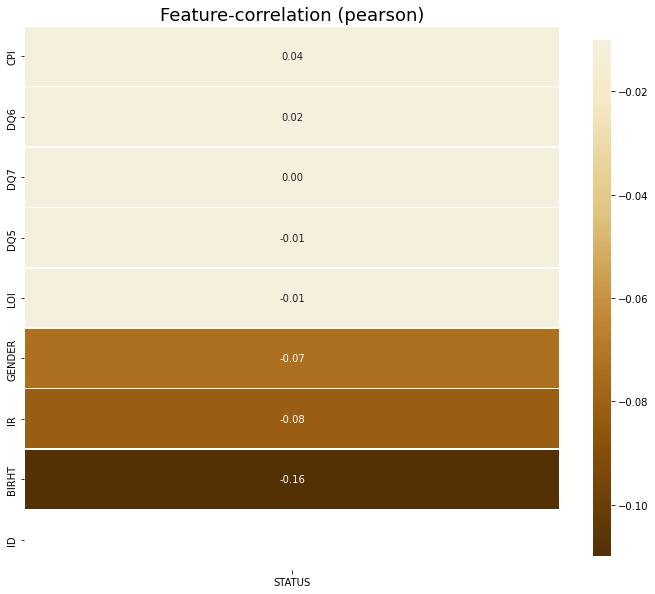

In [ ]:
# 속성간 유사성 파악
# !pip install klib
import klib
# 속성별 예측 능력 파악 
#train 데이터에서 피쳐들이 얼마나 gender를 잘예측하나?
klib.corr_plot(features, target='STATUS')

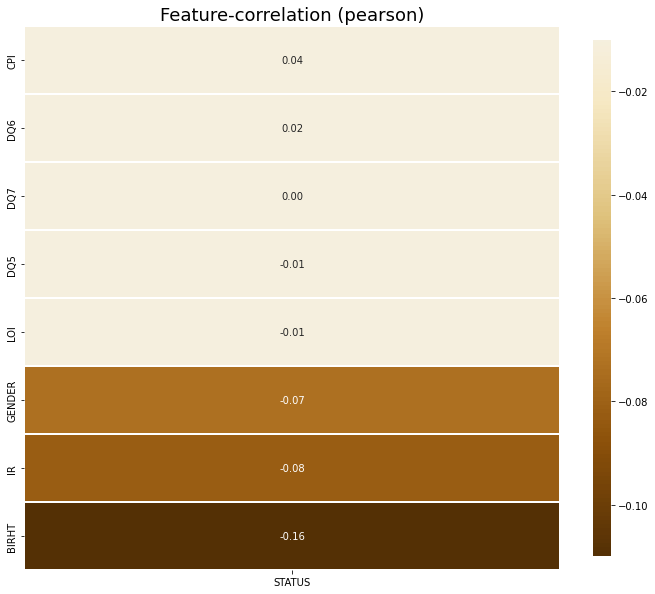

In [ ]:
# 속성별 예측 능력 파악 
#train 데이터에서 피쳐들이 얼마나 gender를 잘예측하나?
klib.corr_plot(train, target='STATUS')

In [ ]:
train.DQ6.isnull().sum()

3340400

### cpi

In [ ]:
full =pd.pivot_table(train.query("STATUS ==1"), index=["userID","DQ6"], values=["CPI"],aggfunc=np.sum).sort_values(by='CPI',ascending=False).reset_index()

In [ ]:
full

,userID,DQ6,CPI
0,p00001,4.0,474830.0
1,p04275,7.0,349430.0
2,p01476,3.0,338025.0
3,p00143,6.0,337125.0
4,p00276,10.0,318305.0
...,...,...,...
3383,p15682,3.0,350.0
3384,p00057,4.0,200.0
3385,p15730,11.0,200.0
3386,p14580,11.0,200.0


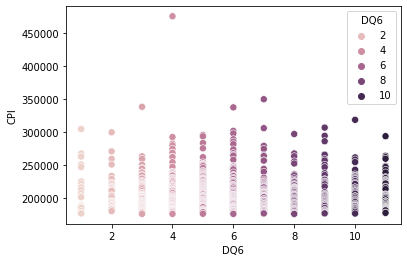

In [ ]:
sns.scatterplot(data=high_cpi, x="DQ6", y="CPI",hue="DQ6", s=50)
plt.show()

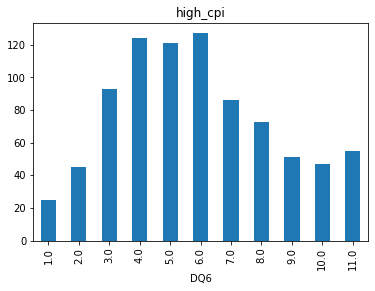

In [ ]:
high_cpi.groupby("DQ6")['userID'].count().plot.bar(title='high_cpi')

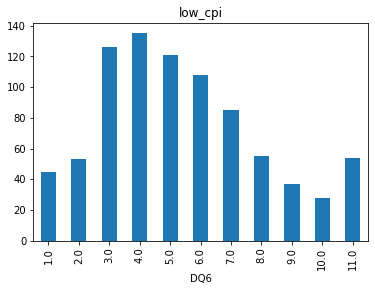

In [ ]:
low_cpi.groupby("DQ6")['userID'].count().plot.bar(title="low_cpi")

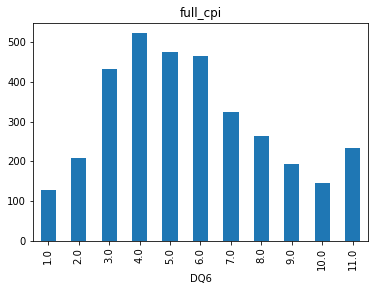

In [ ]:
full.groupby("DQ6")['userID'].count().plot.bar(title="full_cpi")

In [ ]:
# 5 - >12
# 9 -> 16
# 4 -> 13
# 6 - > 1 or 14
# 7 - > 

### DQ2 전처리

In [ ]:
train.DQ2.unique()

array([nan, '9', '16', '17', '99', '3', '4', '18', '97', '1', '6', '22',
       '14', '10', '2', '11', '7', '5', '13', '12', '21', '15', '20',
       '19', '8'], dtype=object)

In [ ]:
train['DQ2']=train["DQ2"].replace(',','',regex=True)
train['DQ2']=train['DQ2'].str.replace(pat=r'[ㄱ-ㅣ가-힣]+', repl= r'', regex=True)
train['DQ2']=train["DQ2"].replace('  ','',regex=True)
train['DQ2']=train["DQ2"].replace('PR','',regex=True)
train['DQ2']=train['DQ2'].str.replace(pat=r'[^a-zA-Z0-9]', repl= r'', regex=True)

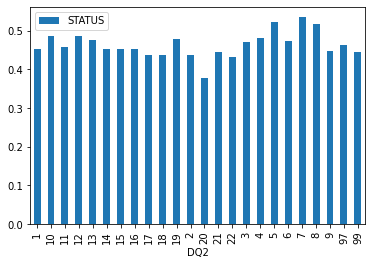

In [ ]:
pd.pivot_table(train, index = ["DQ2"],values=["STATUS"],aggfunc = np.mean).plot.bar()

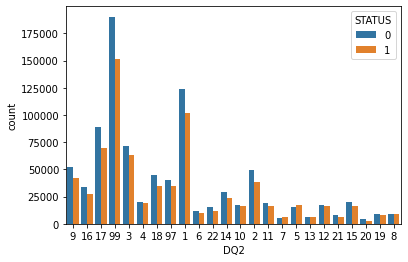

In [ ]:
sns.countplot(data=df2, x="DQ2",hue="STATUS")
plt.show()

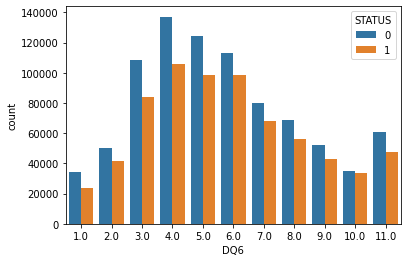

In [ ]:
df2 = train[["DQ6","DQ2",'STATUS']]
sns.countplot(data=df2, x="DQ6",hue="STATUS")
plt.show()

In [ ]:
dq2_df=train[['DQ2',"DQ6","STATUS","userID"]]

In [ ]:
sns.countplot(data=df2, x="DQ2",hue="STATUS")
plt.show()

In [ ]:
loi_df=pd.DataFrame(train[["userID","LOI","STATUS"]].groupby("userID")[["LOI","STATUS"]].mean())
# 설문에 참여한 사람들의 평균 loi

In [ ]:
loi_df=loi_df.sort_values(by="LOI",ascending=True)

In [ ]:
def get_outlier(df, column):
    fraud = df[column]
    qt_25 = np.percentile(fraud.values, 25)
    qt_75 = np.percentile(fraud.values, 75)
    
    
    low_index = fraud[(fraud < qt_25)].index
    
    high_index = fraud[(fraud > qt_75)].index
    
    
    return low_index, high_index

In [ ]:
low_index,high_index = get_outlier(loi_df, "LOI")

In [ ]:
low_loi = loi_df.loc[low_index,:]
high_loi = loi_df.loc[high_index,:]

In [ ]:
loi_df["STATUS"].mean()

0.2710195741971169

In [ ]:
low_loi['STATUS'].mean()

0.35163052863378336

In [ ]:
high_loi["STATUS"].mean()

0.15630663636464354

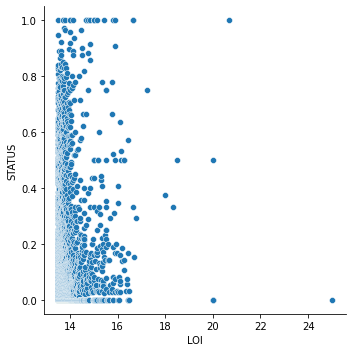

In [ ]:
sns.relplot(data=high_loi, x="LOI", y="STATUS")
plt.show()

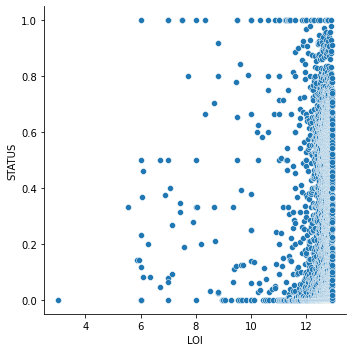

In [ ]:
sns.relplot(data=low_loi, x="LOI", y="STATUS")
plt.show()

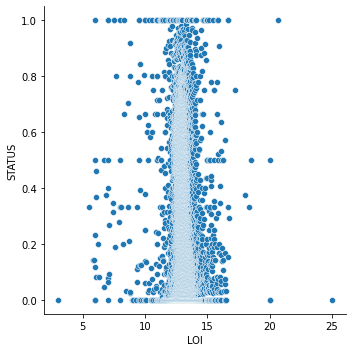

In [ ]:
sns.relplot(data=full_loi_df, x="LOI", y="STATUS")
plt.show()

In [ ]:
job = train[["DQ2","DQ3"]]

In [ ]:
job_drop = job.dropna(axis = 0, how = 'all')
job_drop[job_drop['DQ2'].isnull()]
#DQ2가 null이면 DQ3는 무조건 null

,DQ2,DQ3


In [ ]:
job_drop = job.dropna(axis = 0, how = 'all')
job_drop = job_drop[job_drop.isnull().any(axis=1)];job_drop
# job_drop = job[['DQ2',"DQ3"]].dropna(axis = 0, how = 'all').isnull()

,DQ3,DQ2
16,NaN,4
205,NaN,7
230,NaN,4
744,NaN,9
1063,NaN,4
...,...,...
4898189,NaN,1
4898265,NaN,10
4898884,NaN,1
4898994,NaN,6


### DQ6 전처리

In [ ]:
dq6_na = train[["DQ2","DQ6"]].dropna(axis = 0, how = 'all')
dq6_na = dq6_na[dq6_na.isnull().any(axis=1)];dq6_na

,DQ2,DQ6
16,4,NaN
181,1,NaN
199,99,NaN
205,7,NaN
230,4,NaN
...,...,...
4899044,1,NaN
4899101,3,NaN
4899226,1,NaN
4899249,5,NaN


In [ ]:
job_drop

,DQ2,DQ3


In [ ]:
train

,userID,surveyID,TIME,STATUS,BIRTH,GENDER,REGION,TYPE,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,SQ8,A1,B1,B2,B3,B4,B5,C1,C2,C3,F1,F2,H1,T1,X1,X2,X3,X4,DQ1,DQ2,DQ3,DQ4,DQ5,DQ6,DQ7,TITLE,IR,LOI,CATEGORIES,CPI
0,p04802,s00004,2020-06-01 02:30:11,0,1990.0,2.0,512.0,B,2.0,1990.0,8,3,1,4,"1,13,15,18,2,3,4,5,9",5,2,99,99,99,99,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0
1,p04685,s00004,2020-06-01 02:30:11,0,1984.0,2.0,8.0,B,2.0,1984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0
2,p01206,s00004,2020-06-01 02:30:11,1,1983.0,2.0,16.0,D,2.0,1983.0,6.0,"1,",3.0,"2,",3.0,4,"1,10,11,14,15,16,17,18,2,20,6,7,9",8,3,1,"1,2,3,4,6,8",3,"13,15,2,4,6,8",8,"3,5,6,7,9",6,1,"10,3,5,6,7,8","4,,","15,",1.0,"1,",4,4,9,18,3,8.0,7.0,1.0,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0
3,p00423,s00004,2020-06-01 02:30:11,1,1994.0,1.0,2.0,D,1.0,1994.0,1.0,"1,",3.0,"1,",1.0,4,"13,14,15,17,18,2,21,22,3,6,7,8",8,3,1,"1,2,3,5,7",3,"10,13,14,5",8,"1,2,3,4,5,6,7,8,9","2,","3,","11,5,6","9,,","15,",1.0,"3,",1,4,16,99,"1,",3.0,2.0,1.0,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0
4,p00328,s00004,2020-06-01 02:30:11,1,1980.0,2.0,512.0,D,2.0,1981.0,1,"5,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,해외 - 일반인 의견 조사 (DR 20200531-001)S,100,5,NaN,275.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904544,p13072,s03817,2021-03-23 00:32:12,0,1996.0,2.0,2.0,C,2.0,1996.0,1.0,5,3.0,"2,21,5,8,9",5,3,9,"10,2,6",5,99,"1,2,3,4,5,6,7,8,9",99,16,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,광고 평가 조사 (SP-100163),90,5,etc,250.0
4904545,p08532,s03817,2021-03-23 00:32:12,1,1983.0,1.0,2.0,C,2.0,1985.0,1.0,1,3.0,1,4.0,1,1,3,"2,5",99,1,99,99,99,99,99,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,광고 평가 조사 (SP-100163),90,5,etc,250.0
4904546,p13299,s03817,2021-03-23 00:31:02,1,1996.0,1.0,2.0,C,2.0,1986.0,1.0,1,3.0,1,2.0,1,5,10,3,99,"1,2,3",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,광고 평가 조사 (SP-100163),90,5,etc,250.0
4904547,p14598,s03817,2021-03-23 00:31:02,0,1996.0,1.0,2.0,C,2.0,1983.0,8.0,4,1.0,2,3.0,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,광고 평가 조사 (SP-100163),90,5,etc,250.0


### CPI,LOI,IR

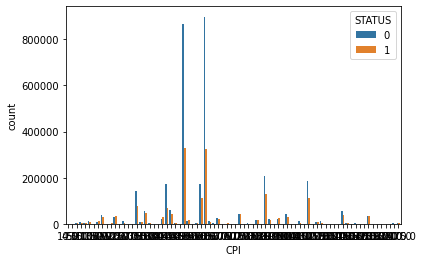

In [ ]:
df2 = train[["CPI","STATUS"]]
sns.countplot(data=df2, x="CPI",hue="STATUS")
plt.show()

In [ ]:
def get_outlier(df, column):
    fraud = df[column]
    qt_25 = np.percentile(fraud.values, 25)
    qt_75 = np.percentile(fraud.values, 75)
    
    
    low_index = fraud[(fraud < qt_25)].index
    
    high_index = fraud[(fraud > qt_75)].index
    
    
    return low_index, high_index



In [ ]:
low_index,high_index = get_outlier(df2, "CPI")
high_cpi=df2.loc[high_index,:]
low_cpi =df2.loc[low_index,:]

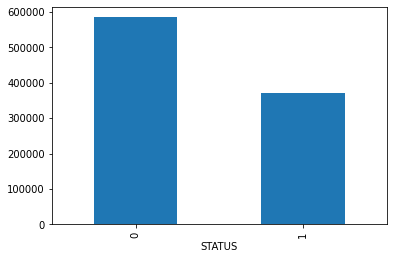

In [ ]:
low_cpi.groupby("STATUS")["CPI"].size().plot.bar()

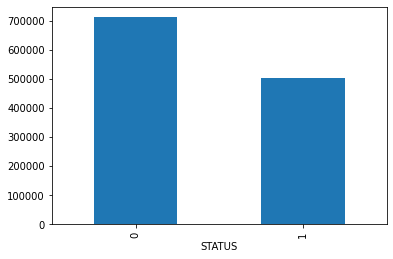

In [ ]:
high_cpi.groupby("STATUS")["CPI"].size().plot.bar()

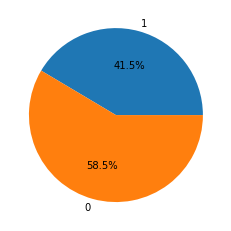

In [ ]:
high_cpi_1 = high_cpi.query("STATUS==1").count()/high_cpi.CPI.count()
high_cpi_0=1-high_cpi_1

labels = ['1', '0']

plt.pie([0.414591,0.585409], labels=labels, autopct='%.1f%%')
plt.show()

#상위 25퍼센트 cpi의 status 비율

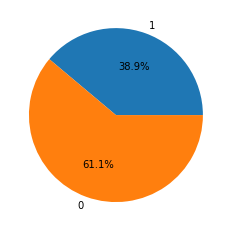

In [ ]:
low_cpi_1 = low_cpi.query("STATUS==1").count()/low_cpi.CPI.count()
low_cpi_0= low_cpi.query("STATUS==0").count()/low_cpi.CPI.count()

labels = ['1', '0']

plt.pie([0.388854,0.611146], labels=labels, autopct='%.1f%%')
plt.show()
#하위 25퍼센트 cpi의 status 비율

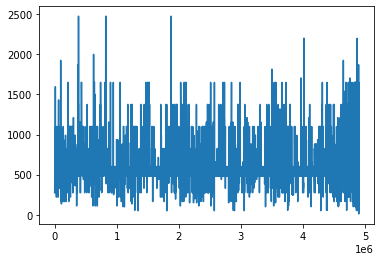

In [ ]:
train.query("STATUS==1")["CPI"].plot.line()
#status==1 중에서 cpi 

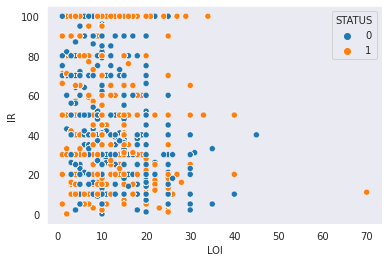

In [ ]:
sns.scatterplot(data=train, x="LOI", y="IR", hue="STATUS")
sns.set_style('dark')
#응답에 걸리는시간과 응답가능성(난이도)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f5515080b90> (for post_execute):


KeyboardInterrupt: ignored

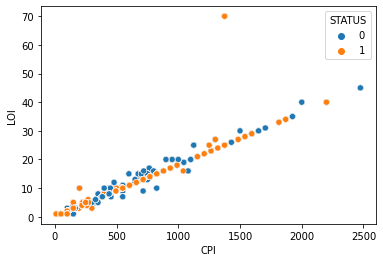

In [ ]:
sns.scatterplot(data=train, x="CPI", y="LOI", hue="STATUS")
sns.set_style('dark')
#응답을 한사람들은 리워드 포인트가 늘어날수록 설문하는데 걸리는 시간이 커진다

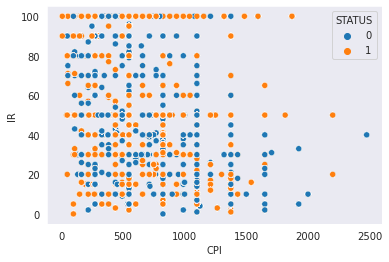

In [ ]:
sns.scatterplot(data=train, x="CPI", y="IR", hue="STATUS")
sns.set_style('dark')

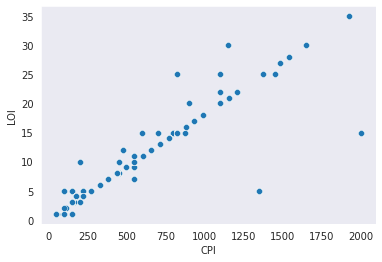

In [ ]:
sns.scatterplot(data=test, x="CPI", y="LOI")
sns.set_style('dark')

In [ ]:
def get_outlier(df, column):
    fraud = df[column]
    qt_5 = np.percentile(fraud.values, 5)
    qt_95 = np.percentile(fraud.values, 95)
    
    
    low_index = fraud[(fraud < qt_5)].index
    
    high_index = fraud[(fraud > qt_95)].index
    
    
    return low_index, high_index

low_index,high_index = get_outlier(df2, "CPI")
high_cpi=df2.loc[high_index,:]
low_cpi =df2.loc[low_index,:]

In [ ]:
df2

,CPI,STATUS
0,275.0,0
1,275.0,0
2,275.0,1
3,275.0,1
4,275.0,1
...,...,...
4904544,250.0,0
4904545,250.0,1
4904546,250.0,1
4904547,250.0,0


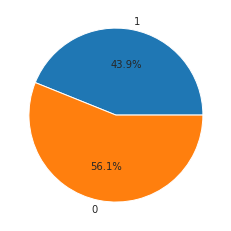

In [ ]:
high_cpi_1 = high_cpi.query("STATUS==1").count()/high_cpi.CPI.count()
high_cpi_0=1-high_cpi_1

labels = ['1', '0']

plt.pie([0.439019,0.560981], labels=labels, autopct='%.1f%%')
plt.show()

#상위 5퍼센트 cpi의 status 비율

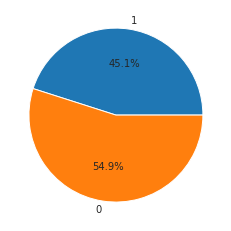

In [ ]:
low_cpi_1 = low_cpi.query("STATUS==1").count()/low_cpi.CPI.count()
low_cpi_0= low_cpi.query("STATUS==0").count()/low_cpi.CPI.count()
# print(low_cpi_0)
labels = ['1', '0']

plt.pie([0.450721,0.549279], labels=labels, autopct='%.1f%%')
plt.show()
#하위 95퍼센트 cpi의 status 비율

In [ ]:
# cpi가 어떤가에 따라 status 는 별로 영향안받음

In [ ]:
df3 = train[["LOI","STATUS","surveyID","userID"]]

In [ ]:
low_index,high_index = get_outlier(df3, "LOI")
high_loi=df3.loc[high_index,:]
low_loi =df3.loc[low_index,:]

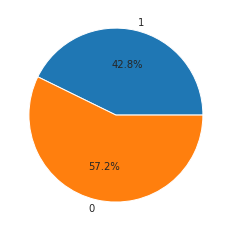

In [ ]:
low_loi_1 = low_loi.query("STATUS==1").count()/low_loi.LOI.count()
low_loi_0= low_loi.query("STATUS==0").count()/low_loi.LOI.count()
# print(low_loi_0)
# print(low_loi_1)
labels = ['1', '0']

plt.pie([0.427522,0.572478], labels=labels, autopct='%.1f%%')
plt.show()

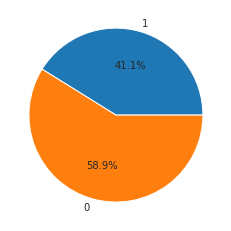

In [ ]:
high_loi_1 = high_loi.query("STATUS==1").count()/high_loi.LOI.count()
high_loi_0= high_loi.query("STATUS==0").count()/high_loi.LOI.count()
# print(high_loi_0)
# print(high_loi_1)
labels = ['1', '0']

plt.pie([0.411428,0.588572], labels=labels, autopct='%.1f%%')
plt.show()

#응답시간이 오래걸리는건 status 0 이 좀 많음

In [ ]:
#LOI는 surveyID에 따라 다르다 

,LOI,STATUS,surveyID,userID
10781,29,0,s00061,p04802
10782,29,0,s00061,p05402
10783,29,1,s00061,p03298
10784,29,1,s00061,p02404
10785,29,0,s00061,p04491
...,...,...,...,...
4899914,16,0,s04674,p09621
4899915,16,0,s04674,p10407
4899923,16,1,s03065,p09414
4899924,16,0,s04284,p09623


In [ ]:
train.groupby("surveyID")['STATUS'].agg(np.mean)
#surveyID별 응답확률

surveyID
s00000    1.000000
s00001    0.363636
s00002    0.439655
s00003    0.000000
s00004    0.369520
            ...   
s04671    0.344029
s04672    1.000000
s04673    0.959184
s04674    0.000000
s04675    0.689655
Name: STATUS, Length: 4676, dtype: float64

In [ ]:
# scaling_L = ["LOI","CPI","IR"]
scaler = MinMaxScaler()
# loi = scaler.fit(train[["LOI"]]).transform(train[["LOI"]])
# cpi = scaler.fit(train[["CPI"]]).transform(train[["CPI"]])
# ir = scaler.fit(train[["IR"]]).transform(train[["IR"]])
df5 = pd.concat([pd.DataFrame(loi),pd.DataFrame(cpi),pd.DataFrame(ir)],axis=1)
df5.columns = ["LOI","CPI","IR"]
df5

,LOI,CPI,IR
0,0.057971,0.107505,1.0
1,0.057971,0.107505,1.0
2,0.057971,0.107505,1.0
3,0.057971,0.107505,1.0
4,0.057971,0.107505,1.0
...,...,...,...
4904544,0.057971,0.097363,0.9
4904545,0.057971,0.097363,0.9
4904546,0.057971,0.097363,0.9
4904547,0.057971,0.097363,0.9


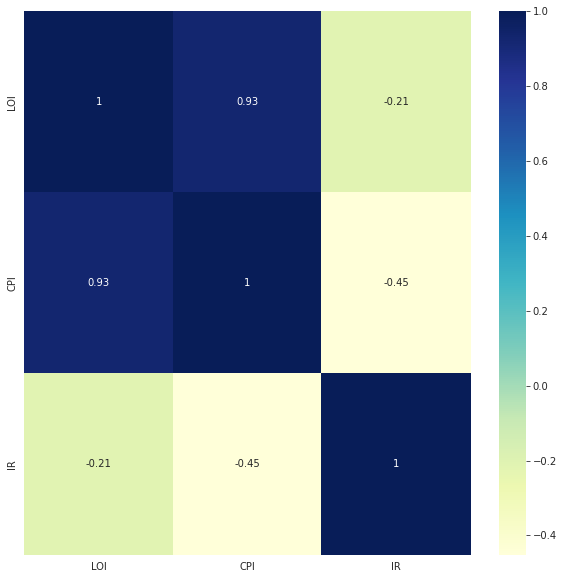

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df5.corr(), annot=True, cmap="YlGnBu")
plt.show()
#CPI : 응답리워드 # LOI : 걸린시간 #Ir : 난이도

In [ ]:
df4 = pd.concat([df4,train["STATUS"]],axis=1)

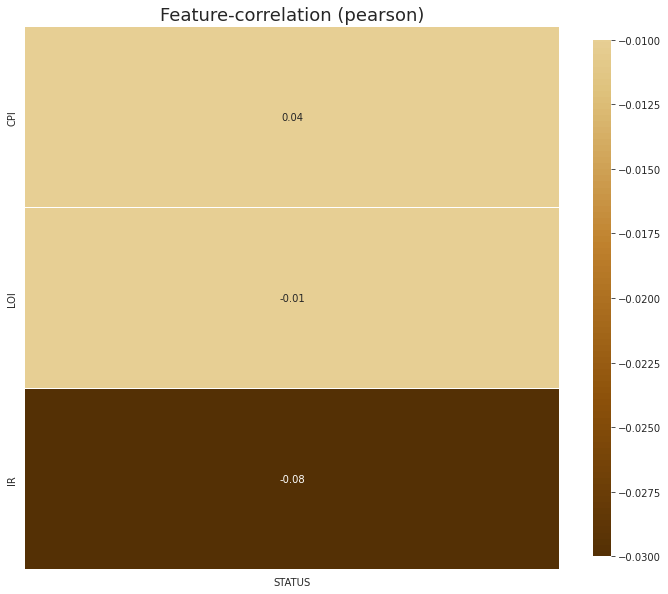

In [ ]:
klib.corr_plot(df4, target='STATUS')

#LOI를 지우거나 PCA하거나

train = ["TIME","BIRTH","GENDER","REGION","TYPE",'TITLE',"IR","CATEGORIES","CPI"].  
target = STATUS.  


### TYPE

In [ ]:
train.groupby("TYPE")["STATUS"].mean()

TYPE
B    0.279353
C    0.090127
D    0.399483
Name: STATUS, dtype: float64

In [ ]:
train.groupby("TYPE")["STATUS"].count()

TYPE
B    1814392
C     269220
D    2820937
Name: STATUS, dtype: int64